# COM2028 Coursework 24/25 Summary

## Question 1 - Model Training and Tuning (40 Marks)

### Question 1.1 (10 Marks)
- **Task:** Improve the validation AUC result by modifying hyperparameters (`num_epochs`, `learning_rate`, and `weight_decay_rate`) to achieve `val_AUC > 0.8`.

### Question 1.2 (10 Marks)
- **Task:** Enhance model performance using data augmentation. Add the following augmentations to the training images:
  1. Random rotations of 10°.
  2. Random horizontal flips with a 50% probability.

### Question 1.3 (10 Marks)
- **Task:** Compare the validation AUC results of two optimisers (Adam and SGD). Automatically select the best-performing optimiser based on the validation AUC results  and run a final training with it.

### Question 1.4 (10 Marks)
- **Task:** Build a new CNN model called `Net2` with the following architecture:
  - **Layer 1**: Input convolutional layer with 32 filters (5x5), followed by ReLU activation and max pooling (kernel size = 3, stride = 3).
  - **Layer fc**: Linear layer with 300 nodes, ReLU activation, and another linear layer with `num_classes` nodes.

---

## Question 2 - Classification Metrics (10 Marks)

### Task:
- **Objective:** Write a function `compute_classification_metrics(all_outputs, all_targets)` to calculate:
  - AUPR (Area Under the Precision-Recall Curve).
  - Precision, Recall, and F1 Score for classifications with probability > 0.5.
  - Use `precision_score`, `recall_score`, `f1_score`, `precision_recall_curve`, and `auc` from `sklearn.metrics`.

---

## Question 3 - ROC Curve (10 Marks)

### Task:
- **Objective:** Plot the ROC curve for binary classification. You are given a function to plot the ROC curve but it lacks the necessary definition of which class’s probability to select. Fix the code by selecting the correct probability from the `all_outputs` array.

---

## Question 4 - Confusion Matrix (10 Marks)

### Task:
- **Objective:** Write a function `compute_confusion_matrix(all_outputs, all_targets)` that calculates the confusion matrix for the binary classification problem using the predicted outputs (`all_outputs`) and ground truth labels (`all_targets`).

---

## Question 5 - Cross Validation (10 Marks)

### Question 5.1 (10 Marks)
- **Task:** Fix the incorrect implementation of the cross-validation function `cross_validate_model_with_serious_mistake(combined_dataset, kf, learning_rate, weight_decay_rate, num_epochs)`. Correct it to a functional version: `cross_validate_model(combined_dataset, kf, learning_rate, weight_decay_rate, num_epochs)`.

---

## Question 6 - Fine-Tuning Pre-Trained Model (20 Marks)

### Task:
- **Objective:** Fine-tune a pre-trained ResNet18 model. Make necessary changes to adapt the model for your own classification task.

---

## Question 6.1 - Preprocessing for ResNet18 (10 Marks)

### Task:
- **Objective:** Modify the `train_transform` and `val_test_transform` to:
  1. Resize the images to 224x224 pixels (use `transforms.Resize(224)`).
  2. Convert grayscale images to 3 RGB channels (use `transforms.Lambda(lambda x: x.repeat(3, 1, 1))`).
  3. Normalize the images using the ImageNet normalization statistics (use `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`).

---

## Question 6.2 - Modify ResNet18 Architecture (10 Marks)

### Task:
- **Objective:** Load the pre-trained ResNet18 model from torchvision and modify the final fully connected layer to have `n_classes` output nodes.
  - Ensure the model is initialized with weights from ImageNet (`weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1`).


## Important Notes:

1. **Follow the instructions carefully:** For each question, you will need to modify only the sections of the code that are specified.  In particular, you'll see:

**# YOUR CODE HERE**

**raise NotImplementedError()**

Please replace **raise NotImplementedError()** with your code. **Do not change anything else in the notebook unless directed to do so**.

4. **Testing and validation:** Each change you make will be automatically tested using a set of unit tests that are hidden from this notebook.

5. **Keep the code clean:** For each question, only modify the code within the cells indicated by the question. Do not add extra cells or change the structure of the notebook unless explicitly instructed.

6. **Error handling:** If you encounter any issues or errors, ensure you carefully debug your code. If you are unable to resolve the issue, ask for help, but remember that the solution must follow the given instructions.

7. **Final Submission:** Once you have completed all the questions, submit the notebook as instructed. Make sure to run all the cells to ensure that your changes work correctly. If the notebook crashes at any point, none of the cells will be marked.



In [40]:
# installing MedMNIST dataset
!pip install medmnist

# load main libraries
from tqdm import tqdm
from tqdm import trange
import os
import random
from collections import OrderedDict
from copy import deepcopy


import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             f1_score, precision_recall_curve, auc, roc_auc_score,
                             accuracy_score, roc_curve as sk_roc_curve)
from sklearn.model_selection import KFold
import seaborn as sns

import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [41]:
#CPU or GPU?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set the dataset to BreastMNIST
data_flag = 'breastmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Using device: cuda


In [42]:
# Image pre-processing
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Datasets and DataLoaders
train_dataset = getattr(medmnist, INFO[data_flag]['python_class'])(split='train', transform=train_transform, download=True)
val_dataset = getattr(medmnist, INFO[data_flag]['python_class'])(split='val', transform=val_test_transform, download=True)
test_dataset = getattr(medmnist, INFO[data_flag]['python_class'])(split='test', transform=val_test_transform, download=True)

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

train_evaluator = Evaluator(data_flag, 'train')
val_evaluator = Evaluator(data_flag, 'val')
test_evaluator = Evaluator(data_flag, 'test')

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: 

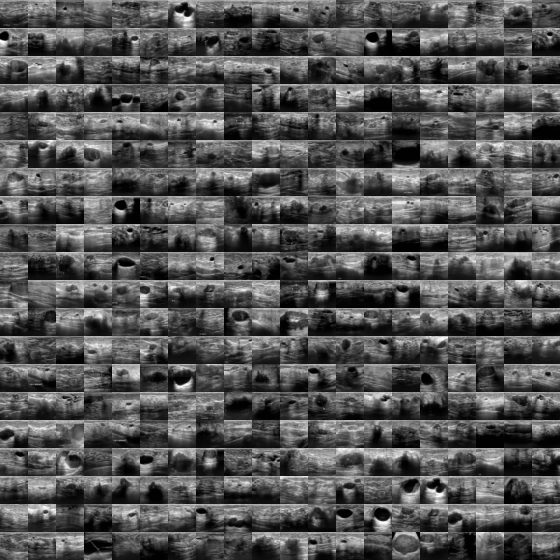

In [43]:
print(train_dataset)
print("===================")
print(test_dataset)
# montage
print("Visualisation of training data")
train_dataset.montage(length=20)

In [44]:
# define a CNN model
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [45]:
# Hyperparameters
learning_rate = 1.0
weight_decay_rate = 0.0
num_epochs = 1
criterion = nn.CrossEntropyLoss()

In [46]:
# Log for storing loss, AUC and accuracy for all three splits
logs = ['loss', 'auc', 'acc']
train_logs = ['train_'+log for log in logs]
val_logs = ['val_'+log for log in logs]
test_logs = ['test_'+log for log in logs]
log_dict = OrderedDict.fromkeys(train_logs+val_logs+test_logs, 0)

In [47]:
def train_model(model, train_loader, criterion, optimiser, device):
    total_loss = []

    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimiser.zero_grad()

        # Moving to GPU for faster computation
        outputs = model(inputs.to(device))

        targets = torch.squeeze(targets, 1).long().to(device) # Fit size
        loss = criterion(outputs, targets)

        total_loss.append(loss.item())

        loss.backward()
        optimiser.step()

    epoch_loss = sum(total_loss)/len(total_loss)
    return epoch_loss

In [48]:
def test_model(model, evaluator, data_loader, criterion, device):
    model.eval()

    total_loss = []
    y_score = torch.tensor([]).to(device)
    all_outputs = torch.tensor([]).to(device)  # Prediction logits
    all_targets = torch.tensor([]).to(device)  # True labels

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            # Storing logits and true labels for use in later computation
            all_outputs = torch.cat((all_outputs, outputs), 0)
            all_targets = torch.cat((all_targets, targets), 0)

            targets = torch.squeeze(targets, 1).long() # Fix size
            loss = criterion(outputs, targets)

            total_loss.append(loss.item())

            # Softmax to get probabilities from logits
            m = nn.Softmax(dim=1)
            prob_outputs = m(outputs).to(device)
            y_score = torch.cat((y_score, prob_outputs), 0)  # Store probabilities separately

    # Using medmnist evaluator to compute auc and acc from probabilities
    y_score = y_score.detach().cpu().numpy()
    auc, acc = evaluator.evaluate(y_score)

    test_loss = sum(total_loss) / len(total_loss)

    # First three will go into the log
    return [test_loss, auc, acc, all_outputs.cpu(), all_targets.cpu()]

In [49]:
def train_val_test_procedure(model, num_epochs, criterion, optimiser, device, train_loader,
                             train_evaluator, train_loader_at_eval, val_evaluator, val_loader,
                             test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs):

    best_auc = 0
    best_epoch = 0
    best_model = deepcopy(model)

    train_loss_values = []
    val_loss_values = []

    for epoch in trange(num_epochs):
        # Train model for this epoch
        train_loss = train_model(model, train_loader, criterion, optimiser, device)

        train_results = test_model(model, train_evaluator, train_loader_at_eval, criterion, device)
        train_metrics = train_results[:3]  # Slices loss, auc, acc to be used in the log
        train_outputs, train_targets = train_results[3:]  # Stores all_outputs and all_targets to be used for computation

        val_results = test_model(model, val_evaluator, val_loader, criterion, device)
        val_metrics = val_results[:3]
        val_outputs, val_targets = val_results[3:]

        test_results = test_model(model, test_evaluator, test_loader, criterion, device)
        test_metrics = test_results[:3]
        test_outputs, test_targets = test_results[3:]

        # Store loss, auc, acc in respective logs
        for i, key in enumerate(train_logs):
            log_dict[key] = train_metrics[i]
        for i, key in enumerate(val_logs):
            log_dict[key] = val_metrics[i]
        for i, key in enumerate(test_logs):
            log_dict[key] = test_metrics[i]

        train_loss_values.append(train_metrics[0])
        val_loss_values.append(val_metrics[0])

        cur_auc = val_metrics[1]

        # Update best model if Val-AUC is new highest
        if cur_auc > best_auc:
            best_epoch = epoch
            best_auc = cur_auc
            best_model = deepcopy(model) # So that model can be stored
            best_outputs = deepcopy(test_outputs)  # Store best outputs for test set with best val auc
            best_targets = deepcopy(test_targets)  # Store best targets for test set with best val auc
            print(f'New best validation AUC: {best_auc} at Epoch: {best_epoch}')


    # Set up the plot
    epochs = range(1, len(train_loss_values) + 1)
    # Plot the losses
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss_values, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss_values, label='Validation Loss', marker='s')
    # Add labels, title, and legend
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_epoch, best_auc, best_model, best_outputs, best_targets

In [50]:
def full_training(model, num_epochs, criterion, optimiser, device, train_loader,train_evaluator, train_loader_at_eval,
                  val_evaluator, val_loader, test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs):

    best_epoch, best_auc, best_model, best_outputs, best_targets= train_val_test_procedure(model, num_epochs, criterion, optimiser, device, train_loader,
                                                                                       train_evaluator, train_loader_at_eval, val_evaluator, val_loader,
                                                                                       test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs)

    train_metrics = test_model(best_model, train_evaluator, train_loader_at_eval, criterion, device)
    val_metrics = test_model(best_model, val_evaluator, val_loader, criterion, device)
    test_metrics = test_model(best_model, test_evaluator, test_loader, criterion, device)

    # Retrieve and print AUC and accuracy for the three splits from the log
    train_log = 'Train   AUC: %.5f  Accuracy: %.5f\n' % (train_metrics[1], train_metrics[2])
    val_log = 'Validation   AUC: %.5f  Accuracy: %.5f\n' % (val_metrics[1], val_metrics[2])
    test_log = 'Test   AUC: %.5f  Accuracy: %.5f\n' % (test_metrics[1], test_metrics[2])

    log = '%s\n' % (data_flag) + train_log + val_log + test_log
    print(log)

    return test_metrics[1], test_metrics[2], best_auc, best_model, best_outputs, best_targets


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

New best validation AUC: 0.5 at Epoch: 0


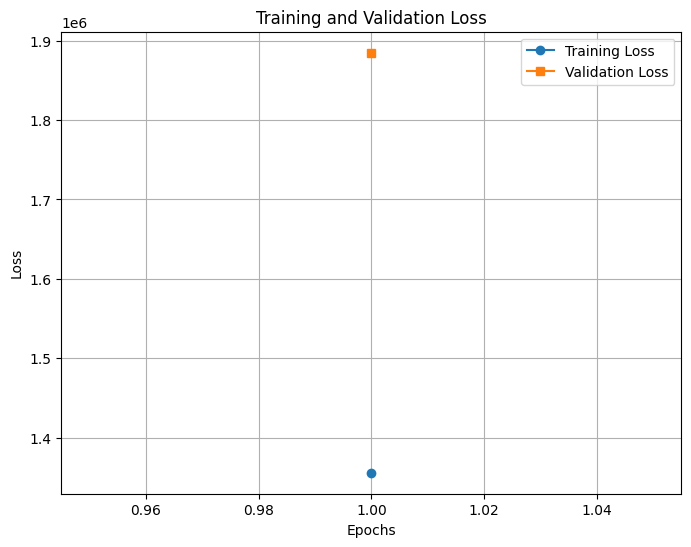

breastmnist
Train   AUC: 0.50000  Accuracy: 0.73077
Validation   AUC: 0.50000  Accuracy: 0.73077
Test   AUC: 0.50000  Accuracy: 0.73077



In [51]:
model = Net(in_channels=n_channels, num_classes=n_classes)
model.to(device)
optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)

test_AUC,test_ACC, val_auc, best_model, best_outputs, best_targets = full_training(model, num_epochs, criterion, optimiser, device, train_loader,train_evaluator, train_loader_at_eval,
                                                                          val_evaluator, val_loader, test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs)

## Question 1

### Task Overview

In this question, you will work on several foundational aspects of classification problems. Your tasks include:

- Defining and tuning hyperparameters.
- Implementing data augmentation techniques.
- Selecting and configuring appropriate optimizers.
- Designing and training a new classification model.

By the end of this task, you will demonstrate your ability to apply core machine learning concepts to build and refine models effectively.


## Question 1.1 (10 Marks)

### Task: Improve Model Performance

Currently, the model's performance is unsatisfactory, with a test AUC below 0.6. Your task is to adjust the following hyperparameters to improve the validation AUC so that `val_AUC > 0.8`:

- `num_epochs`
- `learning_rate`
- `weight_decay_rate`

Experiment with different values and observe how these changes impact the model's performance.

  4%|▍         | 1/25 [00:00<00:12,  1.88it/s]

New best validation AUC: 0.7309941520467835 at Epoch: 0


  8%|▊         | 2/25 [00:01<00:13,  1.68it/s]

New best validation AUC: 0.8370927318295739 at Epoch: 1


 16%|█▌        | 4/25 [00:02<00:16,  1.29it/s]

New best validation AUC: 0.885547201336675 at Epoch: 3


 20%|██        | 5/25 [00:03<00:15,  1.30it/s]

New best validation AUC: 0.9122807017543859 at Epoch: 4


 24%|██▍       | 6/25 [00:04<00:15,  1.22it/s]

New best validation AUC: 0.9381787802840434 at Epoch: 5


 36%|███▌      | 9/25 [00:06<00:12,  1.25it/s]

New best validation AUC: 0.9415204678362572 at Epoch: 8


 48%|████▊     | 12/25 [00:09<00:10,  1.26it/s]

New best validation AUC: 0.9473684210526315 at Epoch: 11


 52%|█████▏    | 13/25 [00:10<00:09,  1.27it/s]

New best validation AUC: 0.9657477025898078 at Epoch: 12


100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


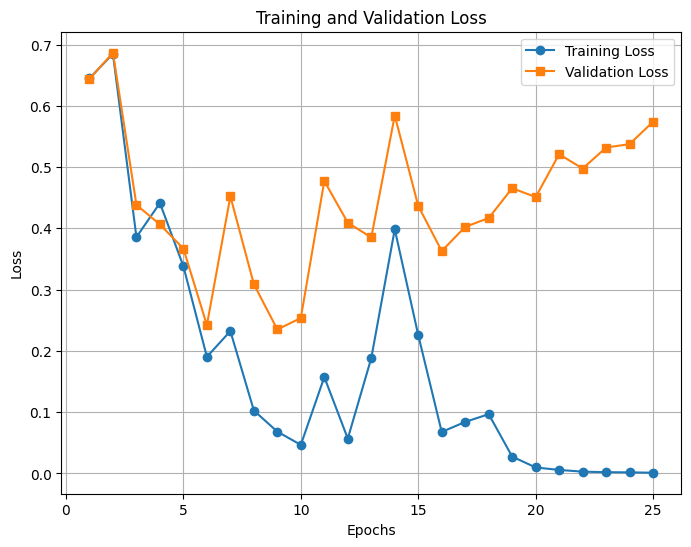

breastmnist
Train   AUC: 0.99720  Accuracy: 0.91026
Validation   AUC: 0.96575  Accuracy: 0.80769
Test   AUC: 0.89077  Accuracy: 0.77564



In [52]:
num_epochs = 1
# change learning_rate, weight_decay_rate, num_epochs to improve val_AUC

learning_rate = 1.0
weight_decay_rate = 0.0
num_epochs = 1

# YOUR CODE HERE
learning_rate = 0.00083
weight_decay_rate = 0.001
num_epochs = 25


model = Net(in_channels=n_channels, num_classes=n_classes)
model.to(device)
optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)

test_AUC,test_ACC, val_AUC, best_model, best_outputs, best_targets = full_training(model, num_epochs, criterion, optimiser, device, train_loader,train_evaluator, train_loader_at_eval,
                                                                          val_evaluator, val_loader, test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs)

In [53]:
print("Please do not erase this cell.")


print("Question 1.1: Improve model performance.")

Please do not erase this cell.
Question 1.1: Improve model performance.


In [54]:
print("Please do not erase this cell.")


print("Question 1.1: Improve model performance.")

Please do not erase this cell.
Question 1.1: Improve model performance.


## Question 1.2 (10 Marks)

### Task: Enhance Model Performance with Data Augmentation

Data augmentation is a simple yet effective technique to improve model performance by artificially increasing the training dataset through geometric and appearance transformations.  

In this question, you will apply the following data augmentations to the training images by modifying `train_transform`:  
1. **Random Rotations**: Apply random rotations up to ±10°.  
2. **Random Horizontal Flips**: Apply random horizontal flips with a probability of 50%.  

Incorporate these transformations and observe how they impact the training process and model performance.


  4%|▍         | 1/25 [00:00<00:15,  1.56it/s]

New best validation AUC: 0.7518796992481203 at Epoch: 0


  8%|▊         | 2/25 [00:01<00:12,  1.84it/s]

New best validation AUC: 0.8162071846282372 at Epoch: 1


 12%|█▏        | 3/25 [00:01<00:11,  1.98it/s]

New best validation AUC: 0.8654970760233918 at Epoch: 2


 16%|█▌        | 4/25 [00:02<00:10,  2.05it/s]

New best validation AUC: 0.8930659983291562 at Epoch: 3


 24%|██▍       | 6/25 [00:03<00:10,  1.82it/s]

New best validation AUC: 0.9147869674185464 at Epoch: 5


 48%|████▊     | 12/25 [00:06<00:06,  1.96it/s]

New best validation AUC: 0.9181286549707602 at Epoch: 11


 68%|██████▊   | 17/25 [00:08<00:03,  2.07it/s]

New best validation AUC: 0.9214703425229741 at Epoch: 16


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


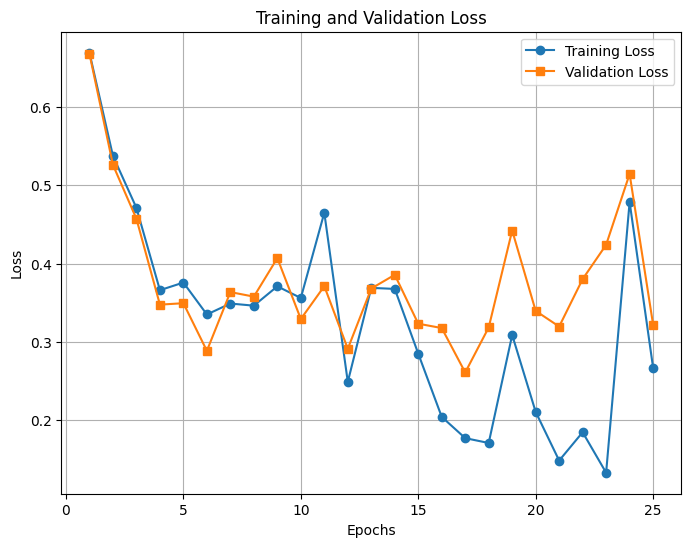

breastmnist
Train   AUC: 0.97850  Accuracy: 0.92674
Validation   AUC: 0.92147  Accuracy: 0.84615
Test   AUC: 0.89202  Accuracy: 0.85256



In [55]:
# Image pre-processing

# redefinition of train_transform
train_transform = transforms.Compose([
    # YOUR CODE HERE
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Datasets and DataLoaders
batch_size = 32
train_dataset = getattr(medmnist, INFO[data_flag]['python_class'])(split='train', transform=train_transform, download=True)
val_dataset = getattr(medmnist, INFO[data_flag]['python_class'])(split='val', transform=val_test_transform, download=True)
test_dataset = getattr(medmnist, INFO[data_flag]['python_class'])(split='test', transform=val_test_transform, download=True)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

train_evaluator = Evaluator(data_flag, 'train')
val_evaluator = Evaluator(data_flag, 'val')
test_evaluator = Evaluator(data_flag, 'test')

model = Net(in_channels=n_channels, num_classes=n_classes)
model.to(device)
optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)

test_AUC,test_ACC, val_AUC, best_model, best_outputs, best_targets = full_training(model, num_epochs, criterion, optimiser, device, train_loader,train_evaluator, train_loader_at_eval,
                                                                          val_evaluator, val_loader, test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs)



In [56]:
print("Please do not erase this cell.")


print("Question 1.2: Data augmentation.")

Please do not erase this cell.
Question 1.2: Data augmentation.


In [57]:
print("Please do not erase this cell.")


print("Question 1.2: Data augmentation.")

Please do not erase this cell.
Question 1.2: Data augmentation.


## Question 1.3 (10 Marks)

### Task: Compare Optimizers and Select the Best One

Optimizers play a critical role in the training process and significantly impact model performance. In this question, you will evaluate and compare the performance of two popular optimizers: **Adam** and **SGD**.  

Your tasks are as follows:  
1. Write a short code snippet to compare the validation AUC results of the two optimizers.  
2. Identify the optimizer that produces the best validation AUC.  
3. Use the selected optimizer to perform a final training run.  

Document your observations and the rationale behind your choice of optimizer.


  4%|▍         | 1/25 [00:00<00:11,  2.09it/s]

New best validation AUC: 0.710108604845447 at Epoch: 0


  8%|▊         | 2/25 [00:00<00:11,  2.07it/s]

New best validation AUC: 0.8036758563074353 at Epoch: 1


 12%|█▏        | 3/25 [00:01<00:10,  2.11it/s]

New best validation AUC: 0.8880534670008354 at Epoch: 2


 16%|█▌        | 4/25 [00:02<00:11,  1.87it/s]

New best validation AUC: 0.8972431077694235 at Epoch: 3


 20%|██        | 5/25 [00:02<00:11,  1.79it/s]

New best validation AUC: 0.9164578111946533 at Epoch: 4


 48%|████▊     | 12/25 [00:06<00:06,  2.00it/s]

New best validation AUC: 0.9289891395154553 at Epoch: 11


 88%|████████▊ | 22/25 [00:11<00:01,  2.10it/s]

New best validation AUC: 0.9331662489557226 at Epoch: 21


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


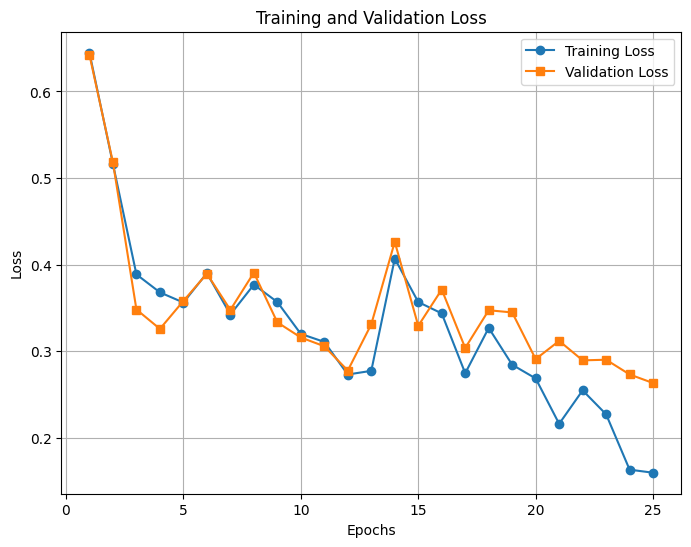

breastmnist
Train   AUC: 0.95209  Accuracy: 0.90293
Validation   AUC: 0.93317  Accuracy: 0.87179
Test   AUC: 0.88283  Accuracy: 0.82051



  4%|▍         | 1/25 [00:00<00:11,  2.03it/s]

New best validation AUC: 0.7468671679197995 at Epoch: 0


 12%|█▏        | 3/25 [00:01<00:12,  1.74it/s]

New best validation AUC: 0.7710944026733499 at Epoch: 2


 24%|██▍       | 6/25 [00:03<00:11,  1.71it/s]

New best validation AUC: 0.7744360902255639 at Epoch: 5


 28%|██▊       | 7/25 [00:03<00:09,  1.82it/s]

New best validation AUC: 0.7861319966583125 at Epoch: 6


 32%|███▏      | 8/25 [00:04<00:08,  1.90it/s]

New best validation AUC: 0.7903091060985798 at Epoch: 7


 40%|████      | 10/25 [00:05<00:07,  2.00it/s]

New best validation AUC: 0.7969924812030076 at Epoch: 9


 44%|████▍     | 11/25 [00:05<00:06,  2.03it/s]

New best validation AUC: 0.8036758563074353 at Epoch: 10


 48%|████▊     | 12/25 [00:06<00:06,  2.06it/s]

New best validation AUC: 0.8270676691729324 at Epoch: 11


 52%|█████▏    | 13/25 [00:06<00:05,  2.07it/s]

New best validation AUC: 0.8362573099415204 at Epoch: 12


 60%|██████    | 15/25 [00:07<00:04,  2.11it/s]

New best validation AUC: 0.8596491228070176 at Epoch: 14


 72%|███████▏  | 18/25 [00:09<00:03,  2.11it/s]

New best validation AUC: 0.8721804511278196 at Epoch: 17


 76%|███████▌  | 19/25 [00:09<00:02,  2.11it/s]

New best validation AUC: 0.8880534670008354 at Epoch: 18


 80%|████████  | 20/25 [00:10<00:02,  2.13it/s]

New best validation AUC: 0.8930659983291562 at Epoch: 19


 84%|████████▍ | 21/25 [00:10<00:01,  2.12it/s]

New best validation AUC: 0.8989139515455304 at Epoch: 20


 88%|████████▊ | 22/25 [00:11<00:01,  2.13it/s]

New best validation AUC: 0.9047619047619048 at Epoch: 21


 92%|█████████▏| 23/25 [00:11<00:00,  2.15it/s]

New best validation AUC: 0.9106098579782791 at Epoch: 22


 96%|█████████▌| 24/25 [00:11<00:00,  2.13it/s]

New best validation AUC: 0.9147869674185464 at Epoch: 23


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]

New best validation AUC: 0.9197994987468672 at Epoch: 24


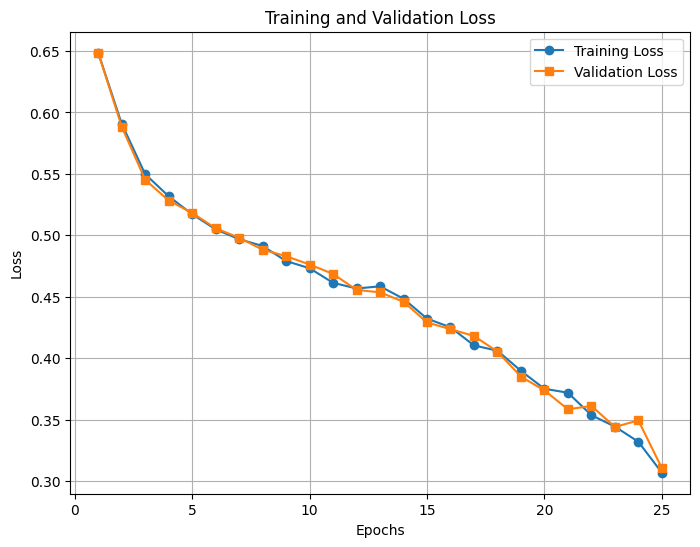

breastmnist
Train   AUC: 0.92555  Accuracy: 0.87912
Validation   AUC: 0.91980  Accuracy: 0.84615
Test   AUC: 0.86383  Accuracy: 0.81410



  4%|▍         | 1/25 [00:00<00:15,  1.53it/s]

New best validation AUC: 0.6741854636591479 at Epoch: 0


  8%|▊         | 2/25 [00:01<00:14,  1.54it/s]

New best validation AUC: 0.7435254803675857 at Epoch: 1


 12%|█▏        | 3/25 [00:02<00:15,  1.43it/s]

New best validation AUC: 0.8329156223893066 at Epoch: 2


 16%|█▌        | 4/25 [00:02<00:13,  1.61it/s]

New best validation AUC: 0.8471177944862155 at Epoch: 3


 20%|██        | 5/25 [00:03<00:11,  1.75it/s]

New best validation AUC: 0.9081035923141186 at Epoch: 4


 28%|██▊       | 7/25 [00:03<00:09,  1.93it/s]

New best validation AUC: 0.9147869674185463 at Epoch: 6


 44%|████▍     | 11/25 [00:05<00:06,  2.11it/s]

New best validation AUC: 0.9415204678362573 at Epoch: 10


 80%|████████  | 20/25 [00:10<00:02,  2.09it/s]

New best validation AUC: 0.9423558897243107 at Epoch: 19


100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


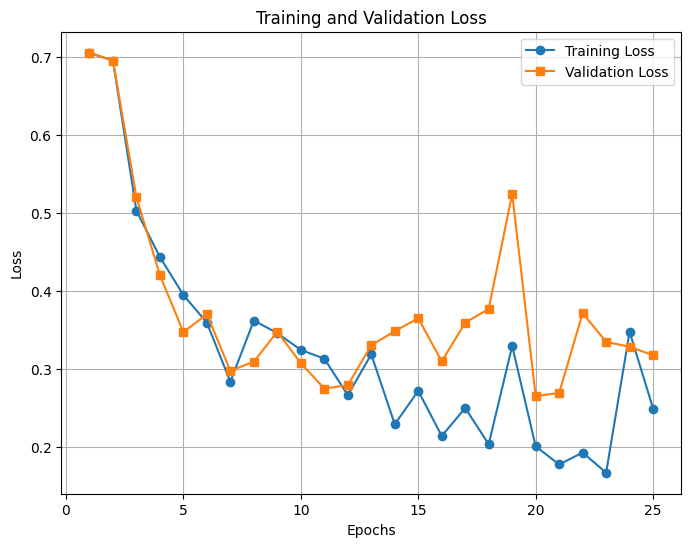

breastmnist
Train   AUC: 0.97482  Accuracy: 0.93040
Validation   AUC: 0.94236  Accuracy: 0.88462
Test   AUC: 0.88283  Accuracy: 0.85256



In [58]:
model = Net(in_channels=n_channels, num_classes=n_classes)
model.to(device)

# Select Adam optimiser
# YOUR CODE HERE
optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)

_,_,val_AUC_Adam, _, _,_ = full_training(model, num_epochs, criterion, optimiser, device, train_loader,train_evaluator, train_loader_at_eval,
                                                                          val_evaluator, val_loader, test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs)

model = Net(in_channels=n_channels, num_classes=n_classes)
model.to(device)

# Select SGD optimiser
# YOUR CODE HERE
optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay_rate)

_,_,val_AUC_SGD, _, _,_ = full_training(model, num_epochs, criterion, optimiser, device, train_loader,train_evaluator, train_loader_at_eval,
                                                                          val_evaluator, val_loader, test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs)

model = Net(in_channels=n_channels, num_classes=n_classes)
model.to(device)

# Select the best of the two optimisers
# YOUR CODE HERE
if val_AUC_Adam > val_AUC_SGD:
  optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)

test_AUC,test_ACC, val_AUC, best_model, best_outputs, best_targets = full_training(model, num_epochs, criterion, optimiser, device, train_loader,train_evaluator, train_loader_at_eval,
                                                                          val_evaluator, val_loader, test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs)


In [59]:
print("Please do not erase this cell.")


print("Question 1.3: Select optimiser.")

Please do not erase this cell.
Question 1.3: Select optimiser.


## Question 1.4 (10 Marks)

### Task: Build a New CNN Model from Scratch

In this question, you will design and train a new convolutional neural network (CNN) model. Follow the steps below to define a new class called `Net2` and train a model named `model2`.  

### Architecture of `Net2`:
1. **Layer 1**:  
   - Convolutional layer with 32 filters of size \(5 \times 5\).  
   - Followed by a ReLU activation function.  
   - Max pooling with kernel size = 3 and stride = 3.  
   
2. **Fully Connected (fc) Layer**:  
   - Linear layer with 300 nodes, followed by a ReLU activation function.  
   - Another linear layer with `num_classes` nodes for classification.  

### Instructions:
- Implement the `Net2` class with the specified architecture.  
- Train the `model2` using the new architecture.  
- Ensure that the training code and hyperparameter configuration are included.  

Document your observations and report the model's performance metrics (e.g., accuracy, AUC) on the validation and test sets.


  4%|▍         | 1/25 [00:00<00:14,  1.69it/s]

New best validation AUC: 0.5981620718462825 at Epoch: 0


 24%|██▍       | 6/25 [00:02<00:08,  2.36it/s]

New best validation AUC: 0.681704260651629 at Epoch: 5


 28%|██▊       | 7/25 [00:03<00:07,  2.36it/s]

New best validation AUC: 0.7869674185463659 at Epoch: 6


 36%|███▌      | 9/25 [00:03<00:06,  2.42it/s]

New best validation AUC: 0.7928153717627402 at Epoch: 8


 40%|████      | 10/25 [00:04<00:06,  2.43it/s]

New best validation AUC: 0.8036758563074353 at Epoch: 9


 48%|████▊     | 12/25 [00:05<00:05,  2.47it/s]

New best validation AUC: 0.8053467000835421 at Epoch: 11


 56%|█████▌    | 14/25 [00:05<00:04,  2.50it/s]

New best validation AUC: 0.808688387635756 at Epoch: 13


 60%|██████    | 15/25 [00:06<00:03,  2.51it/s]

New best validation AUC: 0.8279030910609857 at Epoch: 14


 88%|████████▊ | 22/25 [00:09<00:01,  2.47it/s]

New best validation AUC: 0.835421888053467 at Epoch: 21


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]

New best validation AUC: 0.8462823725981621 at Epoch: 24


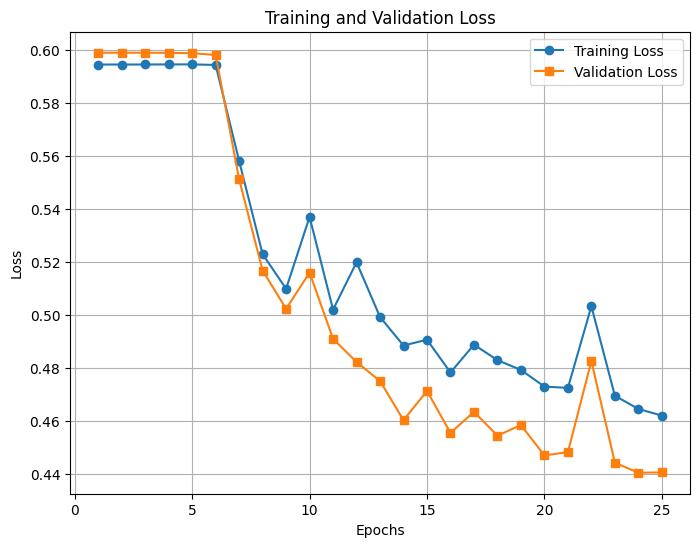

breastmnist
Train   AUC: 0.83005  Accuracy: 0.85165
Validation   AUC: 0.84628  Accuracy: 0.88462
Test   AUC: 0.84137  Accuracy: 0.82051



In [60]:
# define the new CNN model
class Net2(nn.Module):
    # YOUR CODE HERE
    def __init__(self, in_channels, num_classes):
        super(Net2, self).__init__()
        # Define the first convolutional layer with  32 output channels, kernel size 5,
        # ReLU activation, & max pooling layer with kernel size 3 and stride 3
        self.crm = nn.Sequential(
            nn.Conv2d(in_channels, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )
        # Define the first fully connected layer with 32*8*8 input features and 300 output features
        self.fc = nn.Sequential(
            nn.Linear(32 * 8 * 8, 300),
            nn.ReLU(),
            nn.Linear(300, num_classes)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass through first convolutional layer and activation function
        x = self.crm(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

model2 = Net2(in_channels=n_channels, num_classes=n_classes)
model2.to(device)
optimiser = optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)

_,_, _, _,_,_ = full_training(model2, num_epochs, criterion, optimiser, device, train_loader,train_evaluator, train_loader_at_eval,
                            val_evaluator, val_loader, test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs)


In [61]:
print("Please do not erase this cell.")


print("Question 1.4: New CNN model.")

Please do not erase this cell.
Question 1.4: New CNN model.


## Question 2 (10 Marks)

### Task: Compute and Analyze Classification Metrics

Evaluating the performance of CNN models requires analyzing various metrics that provide insights into their effectiveness. In this question, you will compute some of these key metrics.

### Instructions:
Write a Python function named `compute_classification_metrics(all_outputs, all_targets)` that calculates and returns the following metrics for classifications of the positive class (with probability > 0.5):  
1. **Area Under the Precision-Recall Curve (AUPR)**  
2. **Precision**  
3. **Recall**  
4. **F1 Score**  

### Requirements:
- Use the following functions from `sklearn.metrics`:  
  - `precision_score`  
  - `recall_score`  
  - `f1_score`  
  - `precision_recall_curve`  
  - `auc`  

Ensure your implementation is correct and efficient. Comment your code to explain the key steps.


In [62]:
def compute_classification_metrics(all_outputs, all_targets):

    probability_threshold = 0.5

    # YOUR CODE HERE
    probabilities = all_outputs.detach().cpu().numpy()[:, 1]
    all_targets = all_targets.squeeze().cpu().numpy()

    predicted_labels = (probabilities > probability_threshold)

    precision_score_val = precision_score(all_targets, predicted_labels)
    recall_score_val = recall_score(all_targets, predicted_labels)
    f1_score_val = f1_score(all_targets, predicted_labels)

    precision, recall, _ = precision_recall_curve(all_targets, probabilities)
    auc_pr = auc(recall, precision)

    print(f'AUPR: {auc_pr:.5f}')
    print(f'Precision: {precision_score_val:.5f}')
    print(f'Recall: {recall_score_val:.5f}')
    print(f'F1 Score: {f1_score_val:.5f}')

    return recall, precision, auc_pr, precision_score_val, recall_score_val, f1_score_val


# Recall, precision, auc_pr stored in variables for use in plotting graphs
print('Metrics')
recall, precision, auc_pr, precision_score_val, recall_score_val, f1_score_val = compute_classification_metrics(best_outputs, best_targets)

Metrics
AUPR: 0.94554
Precision: 0.90351
Recall: 0.90351
F1 Score: 0.90351


In [63]:
print("Please do not erase this cell.")


print("Question 2: Classification metrics")

Please do not erase this cell.
Question 2: Classification metrics


In [64]:
print("Please do not erase this cell.")


print("Question 2: Classification metrics")

Please do not erase this cell.
Question 2: Classification metrics


In [65]:
print("Please do not erase this cell.")


print("Question 2: Classification metrics")

Please do not erase this cell.
Question 2: Classification metrics


In [66]:
print("Please do not erase this cell.")


print("Question 2: Classification metrics")

Please do not erase this cell.
Question 2: Classification metrics


## Question 3 (10 Marks)

### Task: Define the Class Probability for Plotting the ROC Curve

The Receiver Operating Characteristic (ROC) curve is a crucial tool for evaluating the performance of classifiers. Since our classification problem involves two classes, it is essential to specify which class probability should be used to plot the ROC curve. In particular, we are interested in the classification of normal/benign cases.

### Instructions:
In this question, we provide a partially implemented function to plot the ROC curve. However, the definition of which class probability to select is missing. Your task is to:
1. Select the appropriate class probability for the normal/benign case from the `all_outputs` array.
2. Use this probability to correctly plot the ROC curve.

### Reminder:
Ensure that the selected probability corresponds to the positive class, as the ROC curve evaluates the trade-off between the true positive rate (sensitivity) and the false positive rate. Your implementation should be correct and result in a valid ROC curve.


probabilities are out of range: {probabilities}. Expected 0 <= probabilities <= 1.


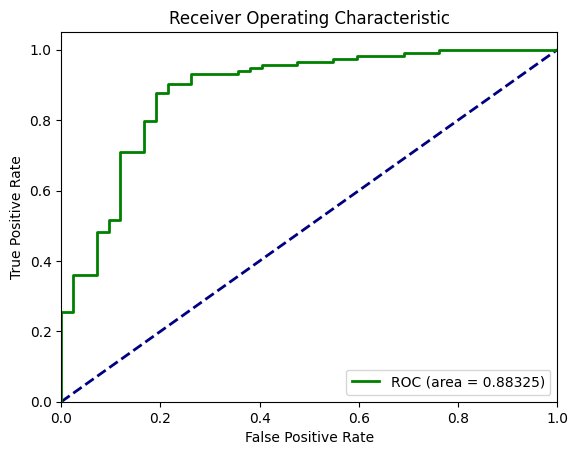

In [67]:
def plot_roc_curve(all_outputs, all_targets, label, color):

    # initialise probabilities
    probabilities = 1.0*torch.ones(best_outputs.shape[0])

    # set the probabilities here:
    # YOUR CODE HERE
    probabilities = all_outputs[:, 1]

    probabilities = probabilities.detach().cpu().numpy()
    if not(np.all((probabilities >= 0) & (probabilities <= 1))):
        print("probabilities are out of range: {probabilities}. Expected 0 <= probabilities <= 1.")

    all_targets = all_targets.squeeze().cpu().numpy()  # Ensure correct shape for sklearn functions

    fpr, tpr, thresholds = sk_roc_curve(all_targets, probabilities)
    roc_auc = auc(fpr, tpr)  # Calculate the area under the curve

    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (area = {roc_auc:.5f})')

    return probabilities

# Set up the plot
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# Plot each model's ROC curve
probabilities = plot_roc_curve(best_outputs, best_targets, label='ROC', color='green')

plt.legend(loc="lower right")
plt.show()

In [68]:
print("Please do not erase this cell.")



print("Question 3: ROC curve")


Please do not erase this cell.
Question 3: ROC curve


In [69]:
print("Please do not erase this cell.")



print("Question 3: ROC curve")


Please do not erase this cell.
Question 3: ROC curve


In [70]:
print("Please do not erase this cell.")



print("Question 3: ROC curve")


Please do not erase this cell.
Question 3: ROC curve


## Question 4 (10 Marks)

### Task: Compute the Confusion Matrix for Classification

In addition to the ROC curve, the confusion matrix is a vital tool for visualizing the performance of a classifier. It provides insights into the true positives, false positives, true negatives, and false negatives, offering a detailed breakdown of classification accuracy.

### Instructions:
Write a Python function named `compute_confusion_matrix(all_outputs, all_targets)` that:  
1. Receives the following inputs:  
   - `all_outputs`: An array containing the classification confidences for each class.  
   - `all_targets`: An array containing the ground-truth labels.  

2. Computes the confusion matrix for the classification task.

### Requirements:
- Ensure that the function correctly maps classification confidences to predicted labels by selecting the class with the highest confidence for each input.  
- Use appropriate functions from libraries like `sklearn.metrics` or implement the logic manually.  
- Comment your code to explain key steps and ensure clarity.

### Deliverables:
- A working definition of the `compute_confusion_matrix` function.  
- Visualize the computed confusion matrix as a heatmap using a library such as Matplotlib or Seaborn (optional but encouraged).  


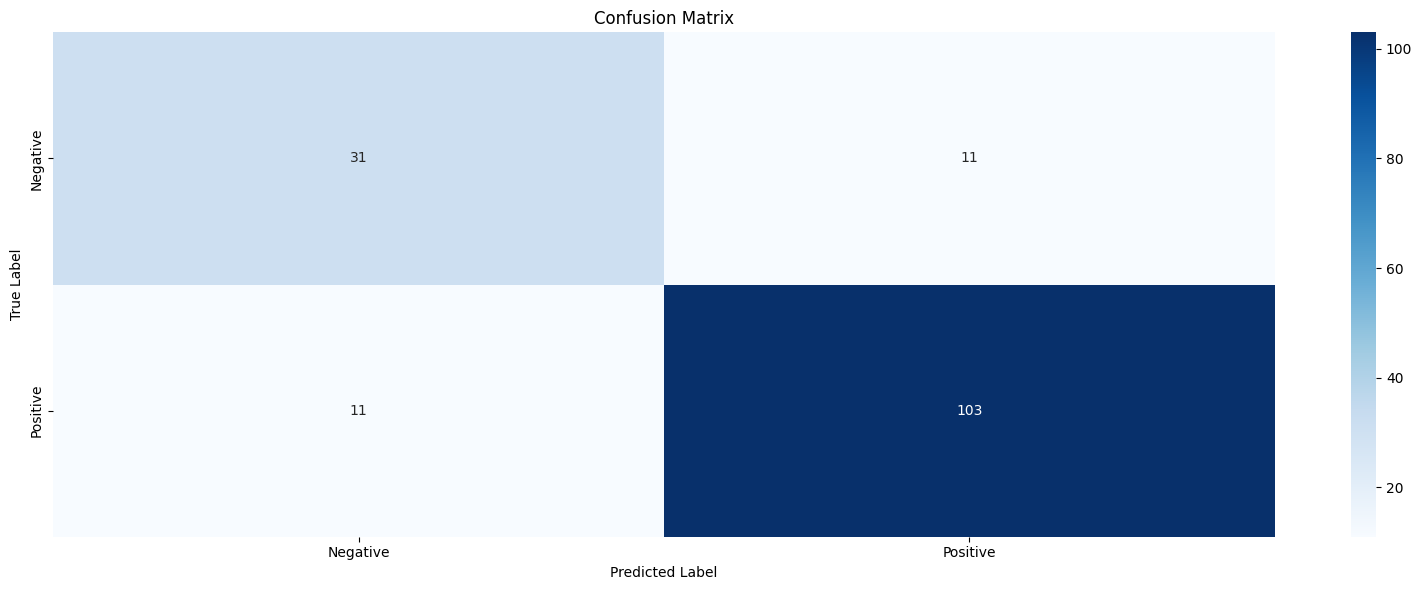

In [71]:
def compute_confusion_matrix(all_outputs, all_targets):
    # initialise confusion matrix
    cm = 100*np.ones((2,2))
    cm[0,0]=90
    cm[1,1]=110

    # YOUR CODE HERE
    probability_threshold = 0.5
    probabilities = all_outputs.detach().numpy()[:, 1]
    all_targets = all_targets.squeeze().numpy()

    predicted_labels = (probabilities > probability_threshold).astype(int)

    cm = confusion_matrix(all_targets, predicted_labels)

    return cm

def plot_confusion_matrix(cm, class_names, title, ax, colour):
    sns.heatmap(cm, annot=True, fmt='d', cmap=colour, xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

cm = compute_confusion_matrix(best_outputs, best_targets)
plot_confusion_matrix(cm, ['Negative', 'Positive'], 'Confusion Matrix', axes,colour='Blues')

plt.tight_layout()
plt.show()


In [72]:
print("Please do not erase this cell.")


print("Question 4: Confusion matrix computation.")


Please do not erase this cell.
Question 4: Confusion matrix computation.


In [73]:
print("Please do not erase this cell.")


print("Question 4: Confusion matrix computation.")


Please do not erase this cell.
Question 4: Confusion matrix computation.


## Question 5 - Cross Validation (10 Marks)

### Task: Implement Cross Validation for Robust Model Assessment

To ensure a more reliable and robust evaluation of a classifier, cross-validation is a standard approach. It provides insights into the model's performance by evaluating it across multiple splits of the dataset, reducing the risk of overfitting to a single data split.

### Instructions:
In this question, you will:  
1. **Combine Datasets**: Concatenate the training, validation, and testing datasets into a single unified dataset.  
2. **Define K-Fold Object**: Use a K-fold cross-validation strategy to split the dataset into `K` subsets (folds).  
3. **Evaluate the Model**: Implement a method to train and evaluate the model using cross-validation. Ensure the model is trained on `K-1` folds and validated on the remaining fold in each iteration.

### Requirements:
- Use a suitable library like `sklearn.model_selection.KFold` for creating the K-fold object.
- Report the average and per-fold metrics (e.g., accuracy, AUC) to summarize the model's performance.
- Comment your code to explain the key steps, such as splitting the data, training the model, and aggregating results.
- Optionally, visualize the fold-specific metrics for better interpretation.

### Deliverables:
- A complete implementation of cross-validation for the provided model.
- A summary of cross-validation results, including:
  - Metrics for each fold (e.g., AUC, accuracy).
  - Overall average metrics across all folds.


In [74]:
# Concatenate the data sets and split it into 5 splits.
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset, test_dataset])
kf = KFold(n_splits=5, shuffle=True)

def evaluate_cross_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, torch.squeeze(targets, 1).long())
            total_loss += loss.item()

            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()

            all_probs.extend(probs)
            all_targets.extend(targets.cpu().numpy().squeeze())

    test_loss = total_loss / len(data_loader)

    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)
    auc = roc_auc_score(all_targets, all_probs)
    acc = accuracy_score(all_targets, all_probs > 0.5)

    return test_loss, auc, acc


## Question 5.1 - Fix Cross-Validation Implementation (10 Marks)

### Task: Correct the Implementation of Cross-Validation

The function `cross_validate_model_with_serious_mistake(combined_dataset, kf, learning_rate, weight_decay_rate, num_epochs)` contains a flawed implementation of the cross-validation process. Your task is to identify and correct the mistakes in this function, resulting in a properly implemented function named `cross_validate_model(combined_dataset, kf, learning_rate, weight_decay_rate, num_epochs)`.

### Instructions:
1. **Understand the Provided Code**: Analyze the incorrect implementation of the function `cross_validate_model_with_serious_mistake` to identify logical and procedural errors in the cross-validation process.
2. **Fix the Function**: Modify the function to ensure that the cross-validation is performed correctly, including:
   - Properly splitting the combined dataset into training and validation subsets for each fold using the provided K-fold object (`kf`).
   - Training the model on `K-1` folds and validating it on the remaining fold.
   - Averaging the performance metrics (e.g., AUC, accuracy) across all folds.
3. **Validate Your Fix**: Test the corrected function to ensure that it produces accurate and meaningful cross-validation results.

### Requirements:
- Use the provided `combined_dataset` and `kf` (K-fold object) for the cross-validation process.
- Ensure proper handling of data splits to avoid data leakage.
- Calculate and return the average and per-fold metrics (e.g., AUC, accuracy).
- Comment your code to highlight the fixes made to the original function.

### Deliverables:
- A corrected implementation of the cross-validation function as `cross_validate_model(combined_dataset, kf, learning_rate, weight_decay_rate, num_epochs)`.
- A summary of the cross-validation results, including:
  - Per-fold metrics (e.g., AUC, accuracy).
  - Overall average metrics across all folds.

### Note:
Ensure that the fixed function adheres to best practices in cross-validation and avoids common pitfalls such as reusing the same data for both training and validation in a single fold.


In [75]:
def cross_validate_model_with_serious_mistake(combined_dataset,kf,learning_rate,weight_decay_rate,num_epochs):
    fold_results = []

    model = Net(in_channels=n_channels, num_classes=n_classes)

    for fold, (train_val_index, test_index) in enumerate(kf.split(combined_dataset)):
        # Split train+validation and test datasets
        train_val_subset = torch.utils.data.Subset(combined_dataset, train_val_index)
        test_subset = torch.utils.data.Subset(combined_dataset, test_index)

        # Split train+validation into their own sets
        sub_kf = KFold(n_splits=4, shuffle=True)
        train_index, val_index = next(iter(sub_kf.split(train_val_subset)))
        train_subset = torch.utils.data.Subset(train_val_subset, train_index)
        val_subset = torch.utils.data.Subset(train_val_subset, val_index)

        model.to(device)
        optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)
        criterion = nn.CrossEntropyLoss()


        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        # Training
        for epoch in range(num_epochs):
            train_model(model, train_loader, criterion, optimiser, device)

        # Evaluation
        val_metrics = evaluate_cross_model(model, val_loader, criterion, device)
        test_metrics = evaluate_cross_model(model, test_loader, criterion, device)
        test_auc = test_metrics[1]
        test_acc = test_metrics[2]

        fold_results.append((test_metrics[0], test_auc, test_acc))
        print(f"Fold {fold+1}: Test loss={test_metrics[0]:.4f}, Test AUC={test_auc:.5f}, Test accuracy={test_acc:.5f}")

    return fold_results

# Compute average AUC and accuracy across all 5 folds
results = cross_validate_model_with_serious_mistake(combined_dataset,kf,learning_rate,weight_decay_rate,num_epochs)
average_auc = np.mean([r[1] for r in results])
average_acc = np.mean([r[2] for r in results])

print()
print(f'Average test AUC: {average_auc:.5f}')
print(f'Average test accuracy: {average_acc:.5f}')

Fold 1: Test loss=0.3849, Test AUC=0.93066, Test accuracy=0.87179
Fold 2: Test loss=0.4103, Test AUC=0.94316, Test accuracy=0.87179
Fold 3: Test loss=0.4141, Test AUC=0.95678, Test accuracy=0.88462
Fold 4: Test loss=0.1130, Test AUC=0.98855, Test accuracy=0.96154
Fold 5: Test loss=0.1515, Test AUC=0.97758, Test accuracy=0.96154

Average test AUC: 0.95935
Average test accuracy: 0.91026


In [76]:
def cross_validate_model(combined_dataset,kf,learning_rate,weight_decay_rate,num_epochs):
    fold_results = []
    # initialise fold_results
    for i in range(5): fold_results.append((1.0,1.0,1.0))

    # YOUR CODE HERE
    # Split train+validation and test datasets
    for fold, (train_val_index, test_index) in enumerate(kf.split(combined_dataset)):
      train_val_subset = torch.utils.data.Subset(combined_dataset, train_val_index)
      test_subset = torch.utils.data.Subset(combined_dataset, test_index)

    # Split train+validation into their own sets
      sub_kf = KFold(n_splits=4, shuffle=True)  # Ensuring reproducibility
      train_val_indices = np.array(train_val_index)  # Convert indices to numpy
      train_index, val_index = next(iter(sub_kf.split(train_val_indices)))
      train_subset = torch.utils.data.Subset(combined_dataset, train_val_indices[train_index])
      val_subset = torch.utils.data.Subset(combined_dataset, train_val_indices[val_index])

    # Move model inside loop
      model = Net(in_channels=n_channels, num_classes=n_classes)
      model.to(device)
      optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)
      criterion = nn.CrossEntropyLoss()

    # Training
      for epoch in range(num_epochs):
          train_model(model, train_loader, criterion, optimiser, device)

    # Evaluation
      val_metrics = evaluate_cross_model(model, val_loader, criterion, device)
      test_metrics = evaluate_cross_model(model, test_loader, criterion, device)
      test_auc = test_metrics[1]
      test_acc = test_metrics[2]

      fold_results.append((test_metrics[0], test_auc, test_acc))
      print(f"Fold {fold+1}: Test loss={test_metrics[0]:.4f}, Test AUC={test_auc:.5f}, Test accuracy={test_acc:.5f}")

    return fold_results

# Compute average AUC and accuracy across all 5 folds
results = cross_validate_model(combined_dataset,kf,learning_rate,weight_decay_rate,num_epochs)
average_auc = np.mean([r[1] for r in results])
average_acc = np.mean([r[2] for r in results])

print()
print(f'Average test AUC: {average_auc:.5f}')
print(f'Average test accuracy: {average_acc:.5f}')

Fold 1: Test loss=0.4697, Test AUC=0.88722, Test accuracy=0.83974
Fold 2: Test loss=0.3950, Test AUC=0.90476, Test accuracy=0.87179
Fold 3: Test loss=0.4486, Test AUC=0.84294, Test accuracy=0.80128
Fold 4: Test loss=0.4842, Test AUC=0.87176, Test accuracy=0.85897
Fold 5: Test loss=0.4237, Test AUC=0.88074, Test accuracy=0.84615

Average test AUC: 0.93874
Average test accuracy: 0.92179


In [77]:
print("Please do not erase this cell.")



print("Question 5: Cross validation.")

Please do not erase this cell.
Question 5: Cross validation.


## Question 6 - Fine-Tuning a Pre-Trained ResNet18 Model (20 marks)

### Task: Fine-Tune a Pre-Trained ResNet18 Model

In this question, you will fine-tune a pre-trained ResNet18 model on your dataset. We will guide you through the key modifications required to adapt the model for your task, and you will need to make the necessary changes to ensure the model is correctly fine-tuned.

### Instructions:
1. **Understand the Pre-Trained Model**: Familiarize yourself with the ResNet18 architecture and its pre-trained weights.
2. **Model Adaptation**: Adjust the model for your specific dataset by:
   - Modifying the final layer to match the number of classes in your classification task.
   - Freezing or unfreezing certain layers as needed for fine-tuning.
3. **Optimization**: Choose appropriate hyperparameters (e.g., learning rate) for fine-tuning the model and ensure that the training procedure is set up correctly.
4. **Validation**: Verify that the model fine-tuning process improves the performance on the validation set.

### Deliverables:
- A fine-tuned ResNet18 model.
- Code changes to adapt the pre-trained model and ensure it works with your dataset.
- A brief explanation of the changes you made and the rationale behind them.

### Note:
- Fine-tuning typically involves freezing the early layers (which capture general features) and training only the later layers (which capture task-specific features). Make sure to experiment with different approaches to achieve the best performance.


## Question 6.1 - Preprocessing for Fine-Tuning ResNet18 (10 Marks)

### Task: Modify Image Preprocessing for ResNet18 Fine-Tuning

The pre-trained ResNet18 model from ImageNet is designed to work with RGB images of size 224x224x3, and the images should be normalized according to the statistics learned from the ImageNet dataset.

In this question, you need to modify the `train_transform` and `val_test_transform` to ensure that the images are preprocessed correctly for fine-tuning with ResNet18. Specifically, you need to make the following changes:

1. **Resize the Images**: The input size for ResNet18 is 224x224 pixels. Use `transforms.Resize(224)` to resize the images to this size.
   
2. **Convert to RGB Channels**: The ResNet18 model expects 3 channels (RGB). If your images are grayscale (1 channel), you need to convert them to 3 channels. Use `transforms.Lambda(lambda x: x.repeat(3, 1, 1))` for this transformation.

3. **Normalize the Images**: The images should be normalized using the mean and standard deviation values derived from the ImageNet dataset. Use `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` for this normalization step.

### Deliverables:
- Updated `train_transform` and `val_test_transform` that resize, convert to RGB, and normalize images as described.
- Brief explanation of the transformations applied.

### Hint:
- Carefully check the order of transformations. The resize operation should be applied before the conversion to RGB channels and normalization.


In [78]:
# Image pre-processing
train_transform = transforms.Compose([
    # YOUR CODE HERE
    transforms.Resize(224),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # YOUR CODE HERE
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    # YOUR CODE HERE
    transforms.Resize(224),
    transforms.ToTensor(),
    # YOUR CODE HERE
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.224, 0.225])
])

# Datasets and DataLoaders
train_dataset = getattr(medmnist, INFO[data_flag]['python_class'])(split='train', transform=train_transform, download=True)
val_dataset = getattr(medmnist, INFO[data_flag]['python_class'])(split='val', transform=val_test_transform, download=True)
test_dataset = getattr(medmnist, INFO[data_flag]['python_class'])(split='test', transform=val_test_transform, download=True)

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

train_evaluator = Evaluator(data_flag, 'train')
val_evaluator = Evaluator(data_flag, 'val')
test_evaluator = Evaluator(data_flag, 'test')

In [79]:
print("Please do not erase this cell.")


print("Question 6.1: Change the train_transform and val_test_transform.")


Please do not erase this cell.
Question 6.1: Change the train_transform and val_test_transform.


In [80]:
print("Please do not erase this cell.")


print("Question 6.1: Change the train_transform and val_test_transform.")


Please do not erase this cell.
Question 6.1: Change the train_transform and val_test_transform.


## Question 6.2 - Modify the ResNet18 Architecture (10 Marks)

### Task: Load and Modify the Pre-Trained ResNet18 Model

In this question, you will load the pre-trained ResNet18 model from torchvision and modify it for your classification task.

1. **Load the Pre-Trained ResNet18 Model**:
   - Use the `torchvision.models.resnet18` function to load the ResNet18 model.
   - Ensure that the model is initialized with weights from the ImageNet dataset (use `weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1` as per the torchvision documentation).

2. **Modify the Final Fully Connected Layer**:
   - After loading the model, modify the final fully connected layer (`model.fc`) to have `n_classes` output nodes, where `n_classes` is the number of classes in your classification task.

### Deliverables:
- Code that loads the ResNet18 model with ImageNet weights and modifies the final fully connected layer to match the number of classes in your dataset.

### Hint:
- The final fully connected layer is typically accessed via `model.fc`. You will need to update its output dimension to match `n_classes`.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
 20%|██        | 1/5 [00:03<00:13,  3.29s/it]

New best validation AUC: 0.5764411027568922 at Epoch: 0


 40%|████      | 2/5 [00:06<00:10,  3.44s/it]

New best validation AUC: 0.7644110275689223 at Epoch: 1


 60%|██████    | 3/5 [00:10<00:06,  3.36s/it]

New best validation AUC: 0.8387635756056808 at Epoch: 2


 80%|████████  | 4/5 [00:13<00:03,  3.34s/it]

New best validation AUC: 0.8880534670008354 at Epoch: 3


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


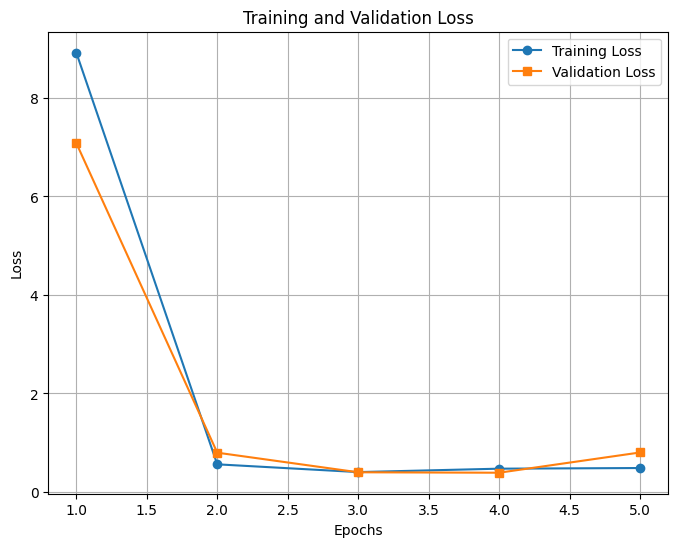

breastmnist
Train   AUC: 0.89116  Accuracy: 0.80220
Validation   AUC: 0.88805  Accuracy: 0.78205
Test   AUC: 0.86842  Accuracy: 0.80128



In [81]:
from torchvision import models

# Model setup
# Initialize from our Net model
model_RN18 = Net(in_channels=n_channels, num_classes=n_classes)

# YOUR CODE HERE
weights = models.ResNet18_Weights.IMAGENET1K_V1
model_RN18 = models.resnet18(weights)

model_RN18.fc = nn.Linear(in_features =512,out_features=n_classes)

model_RN18.to(device)

optimiser = optim.Adam(model_RN18.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)
num_epochs = 5
test_AUC,test_ACC, val_auc, best_model, best_outputs, best_targets = full_training(model_RN18, num_epochs, criterion, optimiser, device, train_loader,train_evaluator, train_loader_at_eval,
                                                                          val_evaluator, val_loader, test_evaluator, test_loader, log_dict, train_logs, val_logs, test_logs)



In [82]:
print("Please do not erase this cell.")


print("Question 6.2: ResNet18.")



Please do not erase this cell.
Question 6.2: ResNet18.


In [83]:
print("Please do not erase this cell.")


print("Question 6.2: ResNet18.")



Please do not erase this cell.
Question 6.2: ResNet18.
